CELL 1: SETUP AND IMPORTS

In [2]:
# --- Core Physics & Math Library ---
import numpy as np  # Handles all vector states (spins), weight matrices, and linear algebra operations.

# --- Data Visualization Libraries ---
import matplotlib.pyplot as plt  # For plotting digit patterns and state trajectories.
import seaborn as sns  # For generating statistical heatmaps and aesthetic plots.

# --- Experiment Management ---
import pandas as pd  # Stores simulation results (accuracy, entropy, noise levels) for analysis.
from tqdm.notebook import tqdm  # Provides progress bars to track long-running simulations.

# --- Dataset Loader ---
import tensorflow as tf  # utilized SOLELY for downloading the MNIST dataset.

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.4) # optimized for readability in papers

print("Computational environment initialized successfully.")

Libraries imported successfully.


CELL 2: EXPERIMENT CONFIGURATION

In [3]:
# This dictionary serves as the central control panel for the entire simulation.
# It defines the physical constants, system dimensions, and experimental variables.

CONFIG = {
    # --- Physical System Dimensions ---
    "NUM_NEURONS": 784,  # System Size (N). Corresponds to the 28x28 pixel grid of MNIST digits.
    "DIGITS_TO_STORE": list(range(10)), # The set of Memory Patterns (xi^mu) available for storage.

    # --- Network Topology Variants ---
    # We compare two distinct network architectures:
    # 1. Standard Hebbian (0.0): Fully symmetric weight matrix (Ising-like).
    # 2. Biological (0.2): 20% of neurons are inhibitory, breaking symmetry (Dale's Principle).
    "INHIBITORY_FRACTIONS_TO_TEST": [0.0, 0.2],

    # --- Experiment 1: Phase Transition / Noise Robustness ---
    # We sweep the noise level (Temperature equivalent) from 0% to 50% to observe the ferromagnetic-paramagnetic transition.
    "NOISE_LEVELS_EXP1": np.linspace(0.0, 0.5, 11),

    # --- Experiment 3: Storage Capacity ---
    # We test the load parameter alpha = M/N by incrementally storing 1 to 10 patterns.
    "CAPACITY_TEST_PATTERNS_EXP3": list(range(1, 11)),

    # --- Statistical Controls ---
    "NUM_RUNS_PER_CONDITION": 20, # Ensemble Size. We average over 20 independent trials to minimize statistical fluctuations.
    "MAX_RECALL_STEPS": 1500,     # Time Limit. Sufficient for convergence to a fixed point or limit cycle.

    # --- Analysis Metrics (Sample Entropy) ---
    # These parameters tune the sensitivity of the complexity analysis for Experiment 2.
    "SAMPEN_M": 2,          # Embedding Dimension: Length of sequences to compare.
    "SAMPEN_R_FRACTION": 0.2 # Tolerance Threshold: 20% of the energy signal's standard deviation.
}

print("Experimental configuration loaded successfully.")

Configuration loaded.


CELL 3: CORE DEFINITIONS

In [4]:
import numpy as np
from numba import jit

# ---------------------------------------------------------
# OPTIMIZED CORE: JIT-COMPILED DYNAMICS
# ---------------------------------------------------------
@jit(nopython=True)
def _fast_recall_loop(current_state, weights, max_steps, record_energy):
    """
    This function runs the physics simulation at C-speed.
    It uses an incremental energy update (O(N)) instead of full recalculation (O(N^2)).
    """
    N = len(current_state)
    energy_history = np.zeros(max_steps)

    # 1. Calculate Initial Energy (Expensive, but done only once)
    # E = -0.5 * s.T * W * s
    initial_field = weights.astype(np.float64) @ current_state.astype(np.float64)
    current_energy = -0.5 * np.dot(current_state.astype(np.float64), initial_field)

    # 2. The Loop
    for step in range(max_steps):
        # Pick random neuron
        idx = np.random.randint(0, N)

        # Calculate Local Field (h_i)
        local_field = 0.0
        for j in range(N):
            local_field += weights[idx, j] * current_state[j]

        # Update State
        old_spin = current_state[idx]
        new_spin = 1.0 if local_field >= 0 else -1.0

        # 3. Only update energy if the spin actually flipped
        if new_spin != old_spin:
            current_state[idx] = new_spin

            if record_energy:
                # Delta E = -0.5 * Delta(s_i * sum_j w_ij s_j + s_i * sum_k w_ki s_k)
                # For symmetric W: Delta E = - (new - old) * local_field
                # For asymmetric W: We need column sum too.

                # Calculate col_sum:
                col_sum = 0.0
                for k in range(N):
                    col_sum += weights[k, idx] * current_state[k]

                # The change in the quadratic term sWs
                delta_s = new_spin - old_spin
                delta_term = delta_s * (local_field + col_sum)

                # E_new = E_old - 0.5 * delta_term
                current_energy -= 0.5 * delta_term

        if record_energy:
            energy_history[step] = current_energy

    return current_state, energy_history

# ---------------------------------------------------------
# WRAPPER CLASS
# ---------------------------------------------------------
class HopfieldNetwork:
    """
    Optimized Wrapper for the Hopfield Network.
    """
    def __init__(self, num_neurons, inhibitory_fraction=0.0):
        self.N = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons), dtype=np.float64)
        self.inhibitory_neurons = []

        if inhibitory_fraction > 0:
            num_inhibitory = int(self.N * inhibitory_fraction)
            self.inhibitory_neurons = np.random.choice(range(self.N), size=num_inhibitory, replace=False)

    def train(self, patterns):
        M = len(patterns)
        if M == 0: return
        # Standard Hebbian Rule
        # Cast to float64 to ensure Numba compatibility
        self.weights = np.sum([np.outer(p, p) for p in patterns], axis=0).astype(np.float64)
        self.weights /= M
        np.fill_diagonal(self.weights, 0)

        # Apply Inhibition
        if len(self.inhibitory_neurons) > 0:
            self.weights[self.inhibitory_neurons, :] *= -1

    def recall(self, initial_pattern, max_steps=100, record_energy=True):
        # We cast inputs to ensure types match the JIT signature
        state = initial_pattern.astype(np.float64).copy()

        # Call the fast JIT function
        final_state, history = _fast_recall_loop(
            state,
            self.weights,
            int(max_steps),
            record_energy
        )

        return final_state, history

    def calculate_energy(self, state):
        # Fallback for manual checks
        return -0.5 * np.dot(state.T, np.dot(self.weights, state))

# Keep the analysis functions unchanged
def calculate_sampen(time_series, m=2, r_fraction=0.2):
    N = len(time_series)
    if N < m + 1: return 0
    std_dev = np.std(time_series)
    if std_dev == 0: return 0
    r = r_fraction * std_dev
    templates_m = np.array([time_series[i : i + m] for i in range(N - m)])
    templates_m1 = np.array([time_series[i : i + m + 1] for i in range(N - m)])
    B = np.sum(np.abs(templates_m[:, None] - templates_m) <= r) - len(templates_m)
    A = np.sum(np.abs(templates_m1[:, None] - templates_m1) <= r) - len(templates_m1)
    return -np.log(A / B) if A > 0 and B > 0 else 0

def calculate_overlap(state1, state2):
    return np.dot(state1, state2) / len(state1)

def plot_digit(digit_vector, ax, title=""):
    ax.imshow(digit_vector.reshape(28, 28), cmap='gray')
    ax.set_title(title)
    ax.axis('off')

print("Optimized Core Definitions ready (Numba Enabled).")

Optimized Core Definitions ready (Numba Enabled).


CELL 4: LOADING AND PREPROCESSING THE MNIST DATASET

In [5]:
print("\n--- Loading and preparing the MNIST dataset ---")
# Use TensorFlow's Keras API to download the MNIST dataset.
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
# Binarize the images. Pixel values > 127 become +1, others become -1.
# This maps the images to the (+1/-1) states of the neurons.
x_train_binary = np.where(x_train.reshape((x_train.shape[0], -1)) > 127, 1, -1)

# Select one prototype image for each digit we want to store in memory.
digits_to_store = CONFIG["DIGITS_TO_STORE"]
# Find the index of the first occurrence of each digit.
indices = [np.where(y_train == i)[0][0] for i in digits_to_store]
# Create a dictionary mapping the digit label to its pattern vector.
all_patterns = {digit: x_train_binary[index] for digit, index in zip(digits_to_store, indices)}

print(f"{len(all_patterns)} unique digit prototypes are ready for the experiments.")


--- Loading and preparing the MNIST dataset ---
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
10 unique digit prototypes are ready for the experiments.


CELL 5: EXPERIMENT 1 & 2 - NOISE ROBUSTNESS AND DYNAMIC ANALYSIS

In [6]:
def run_noise_robustness_experiment(config, patterns_to_store):

    """A function to run the full noise robustness experiment."""

    all_results = []
    patterns = list(patterns_to_store.values())

    # Loop over the network types we want to test (Standard and Inhibitory).
    for frac in config["INHIBITORY_FRACTIONS_TO_TEST"]:
        print(f"\n--- Running Robustness Experiment: Inhibitory Fraction = {frac} ---")
        net = HopfieldNetwork(config["NUM_NEURONS"], inhibitory_fraction=frac)
        net.train(patterns)

        # Loop over the different noise levels defined in the CONFIG.
        for noise in tqdm(config["NOISE_LEVELS_EXP1"], desc=f"Noise Levels (Inhibition={frac})"):
            # Repeat the experiment multiple times to get reliable statistics.
            for _ in range(config["NUM_RUNS_PER_CONDITION"]):
                original_pattern = patterns[np.random.randint(len(patterns))]

                # Create a corrupted input by flipping a fraction of the bits.
                initial_pattern = original_pattern.copy()
                num_to_flip = int(noise * config["NUM_NEURONS"])
                flip_indices = np.random.choice(range(config["NUM_NEURONS"]), size=num_to_flip, replace=False)
                initial_pattern[flip_indices] *= -1

                # Run the recall process and collect the key observables.
                final_state, energy_history = net.recall(initial_pattern, max_steps=config["MAX_RECALL_STEPS"])
                accuracy = calculate_overlap(final_state, original_pattern)
                entropy = calculate_sampen(energy_history, m=config["SAMPEN_M"], r_fraction=config["SAMPEN_R_FRACTION"])

                # Store the results in a list of dictionaries.
                all_results.append({
                    'noise': noise,
                    'accuracy': accuracy,
                    'entropy': entropy,
                    'inhibitory_fraction': frac
                })
    # Return the results as a Pandas DataFrame for easy analysis.
    return pd.DataFrame(all_results)

# For the robustness experiment, we store a subset of digits (4)
# to ensure the task is challenging but not impossible.
patterns_for_exp1 = {d: p for d, p in all_patterns.items() if d in [0, 1, 2, 8]}
df_exp1_results = run_noise_robustness_experiment(CONFIG, patterns_for_exp1)
print("\nRobustness Experiment completed.")


--- Running Robustness Experiment: Inhibitory Fraction = 0.0 ---


Noise Levels (Inhibition=0.0):   0%|          | 0/11 [00:00<?, ?it/s]


--- Running Robustness Experiment: Inhibitory Fraction = 0.2 ---


Noise Levels (Inhibition=0.2):   0%|          | 0/11 [00:00<?, ?it/s]


Robustness Experiment completed.


CELL 6: EXPERIMENT 3 - MEMORY CAPACITY

In [7]:
def run_capacity_experiment(config, all_patterns):
    """
    A function to run the memory capacity experiment.
    We test how recall accuracy degrades as we store more and more patterns.
    """
    all_results = []

    for frac in config["INHIBITORY_FRACTIONS_TO_TEST"]:
        print(f"\n--- Running Capacity Experiment: Inhibitory Fraction = {frac} ---")
        # Loop over the number of patterns to store, from 1 to 10.
        for num_patterns in tqdm(config["CAPACITY_TEST_PATTERNS_EXP3"], desc=f"Number of Patterns (Inhibition={frac})"):

            # Select the first 'num_patterns' digits.
            current_patterns_to_store = [all_patterns[d] for d in range(num_patterns)]

            net = HopfieldNetwork(config["NUM_NEURONS"], inhibitory_fraction=frac)
            net.train(current_patterns_to_store)

            total_accuracy = 0
            # Test the recall for each stored pattern to get an average accuracy.
            for original_pattern in current_patterns_to_store:
                # Test with a low, fixed noise level (e.g., 10%) to check if the memory is stable.
                initial_pattern = original_pattern.copy()
                num_to_flip = int(0.1 * config["NUM_NEURONS"])
                flip_indices = np.random.choice(range(config["NUM_NEURONS"]), size=num_to_flip, replace=False)
                initial_pattern[flip_indices] *= -1

                # We don't need the energy history here, so we can disable it to save time.
                final_state, _ = net.recall(initial_pattern, max_steps=config["MAX_RECALL_STEPS"], record_energy=False)
                total_accuracy += calculate_overlap(final_state, original_pattern)

            average_accuracy = total_accuracy / num_patterns

            all_results.append({
                'num_patterns': num_patterns,
                'avg_accuracy': average_accuracy,
                'inhibitory_fraction': frac
            })
    return pd.DataFrame(all_results)

df_exp3_results = run_capacity_experiment(CONFIG, all_patterns)
print("\nMemory Capacity Experiment completed.")


--- Running Capacity Experiment: Inhibitory Fraction = 0.0 ---


Number of Patterns (Inhibition=0.0):   0%|          | 0/10 [00:00<?, ?it/s]


--- Running Capacity Experiment: Inhibitory Fraction = 0.2 ---


Number of Patterns (Inhibition=0.2):   0%|          | 0/10 [00:00<?, ?it/s]


Memory Capacity Experiment completed.


CELL 7: PLOTTING FOR REPORT


--- Generating Report Plots ---


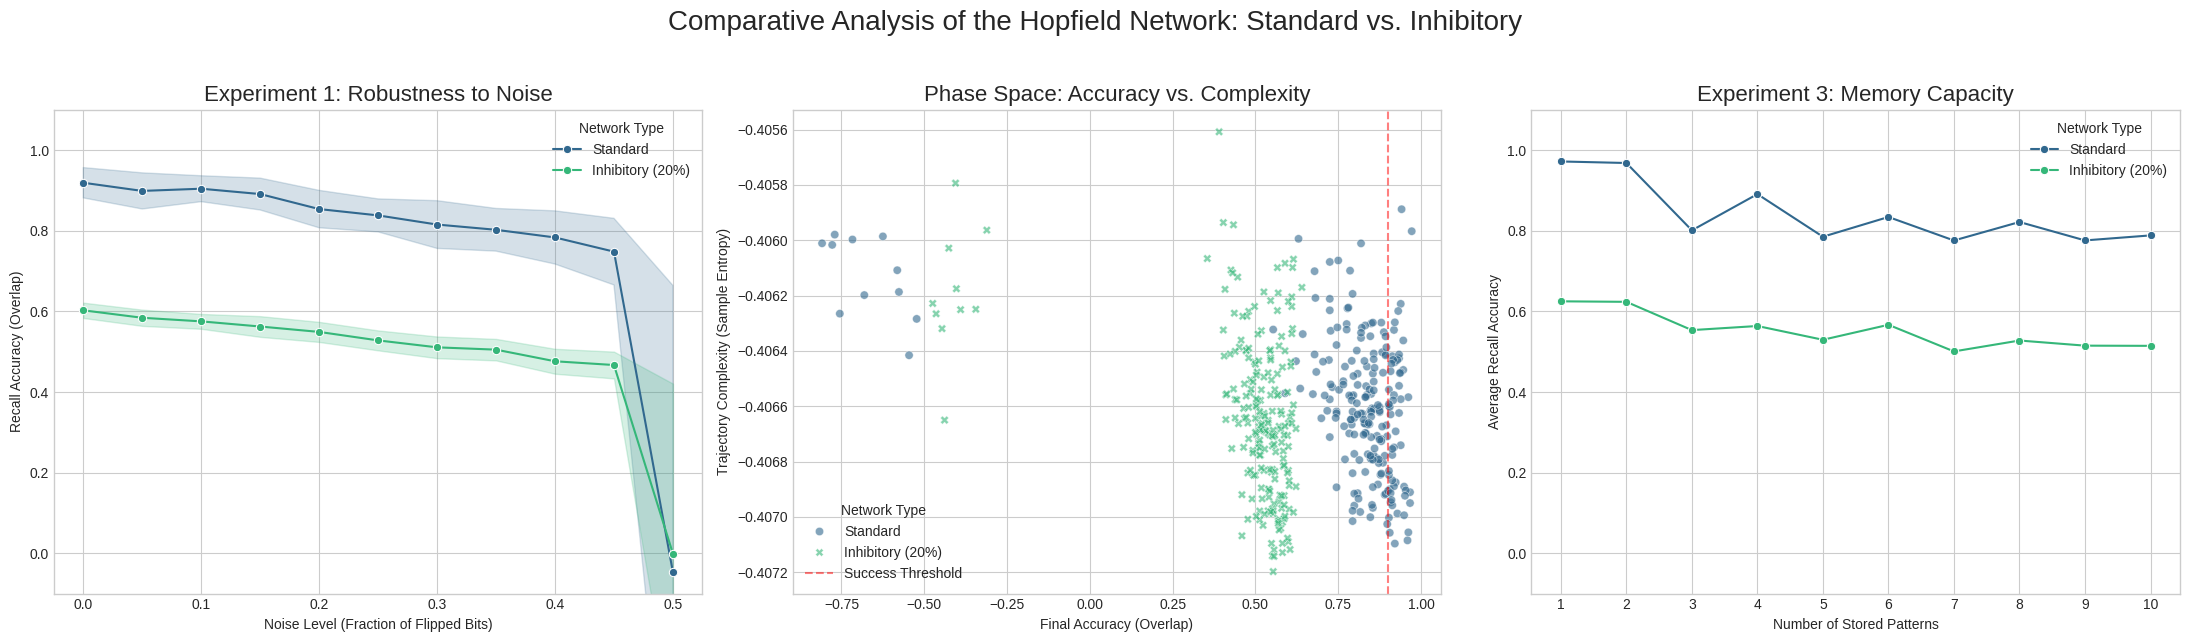

In [8]:
def generate_report_plots(df1, df3):
    """ Generates plots from the experiment results DataFrame. """

    print("\n--- Generating Report Plots ---")
    plt.style.use('seaborn-v0_8-whitegrid')

    # Map the numeric fraction to a readable label for the plot legend.
    df1['Network Type'] = df1['inhibitory_fraction'].map({0.0: 'Standard', 0.2: 'Inhibitory (20%)'})
    df3['Network Type'] = df3['inhibitory_fraction'].map({0.0: 'Standard', 0.2: 'Inhibitory (20%)'})

    # --- Create a figure with 3 subplots for our 3 main results.
    fig, axes = plt.subplots(1, 3, figsize=(22, 6.5))
    fig.suptitle('Comparative Analysis of the Hopfield Network: Standard vs. Inhibitory', fontsize=20)

    # --- Plot 1: Accuracy vs. Noise (Experiment 1) ---
    sns.lineplot(ax=axes[0], data=df1, x='noise', y='accuracy', hue='Network Type', errorbar='sd', palette='viridis', marker='o')
    axes[0].set_title('Experiment 1: Robustness to Noise', fontsize=16)
    axes[0].set_xlabel('Noise Level (Fraction of Flipped Bits)')
    axes[0].set_ylabel('Recall Accuracy (Overlap)')
    axes[0].legend(title='Network Type')
    axes[0].set_ylim(-0.1, 1.1)
    axes[0].grid(True)

    # --- Plot 2: Phase Space of Dynamics (Entropy vs Accuracy) ---
    # A scatter plot to show every single simulation.

    sns.scatterplot(
        ax=axes[1],
        data=df1,
        x='accuracy',
        y='entropy',
        hue='Network Type',
        style='Network Type',
        alpha=0.6,
        palette='viridis'
    )

    axes[1].set_title('Phase Space: Accuracy vs. Complexity', fontsize=16)
    axes[1].set_xlabel('Final Accuracy (Overlap)')
    axes[1].set_ylabel('Trajectory Complexity (Sample Entropy)')

    # Add a vertical line to show our "Success" threshold
    axes[1].axvline(0.9, color='red', linestyle='--', alpha=0.5, label='Success Threshold')
    axes[1].legend(title='Network Type')
    axes[1].grid(True)

    # --- Plot 3: Memory Capacity (Experiment 3) ---
    sns.lineplot(ax=axes[2], data=df3, x='num_patterns', y='avg_accuracy', hue='Network Type', errorbar='sd', palette='viridis', marker='o')
    axes[2].set_title('Experiment 3: Memory Capacity', fontsize=16)
    axes[2].set_xlabel('Number of Stored Patterns')
    axes[2].set_ylabel('Average Recall Accuracy')
    axes[2].legend(title='Network Type')
    axes[2].set_ylim(-0.1, 1.1)
    # Ensure integer ticks on the x-axis.
    if "CAPACITY_TEST_PATTERNS_EXP3" in CONFIG:
        axes[2].set_xticks(CONFIG["CAPACITY_TEST_PATTERNS_EXP3"])
    axes[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Generate the final plots from the collected data.
# This will now use the updated definition of success.
generate_report_plots(df_exp1_results, df_exp3_results)

CELL 8: STATE SPACE TRAJECTORY

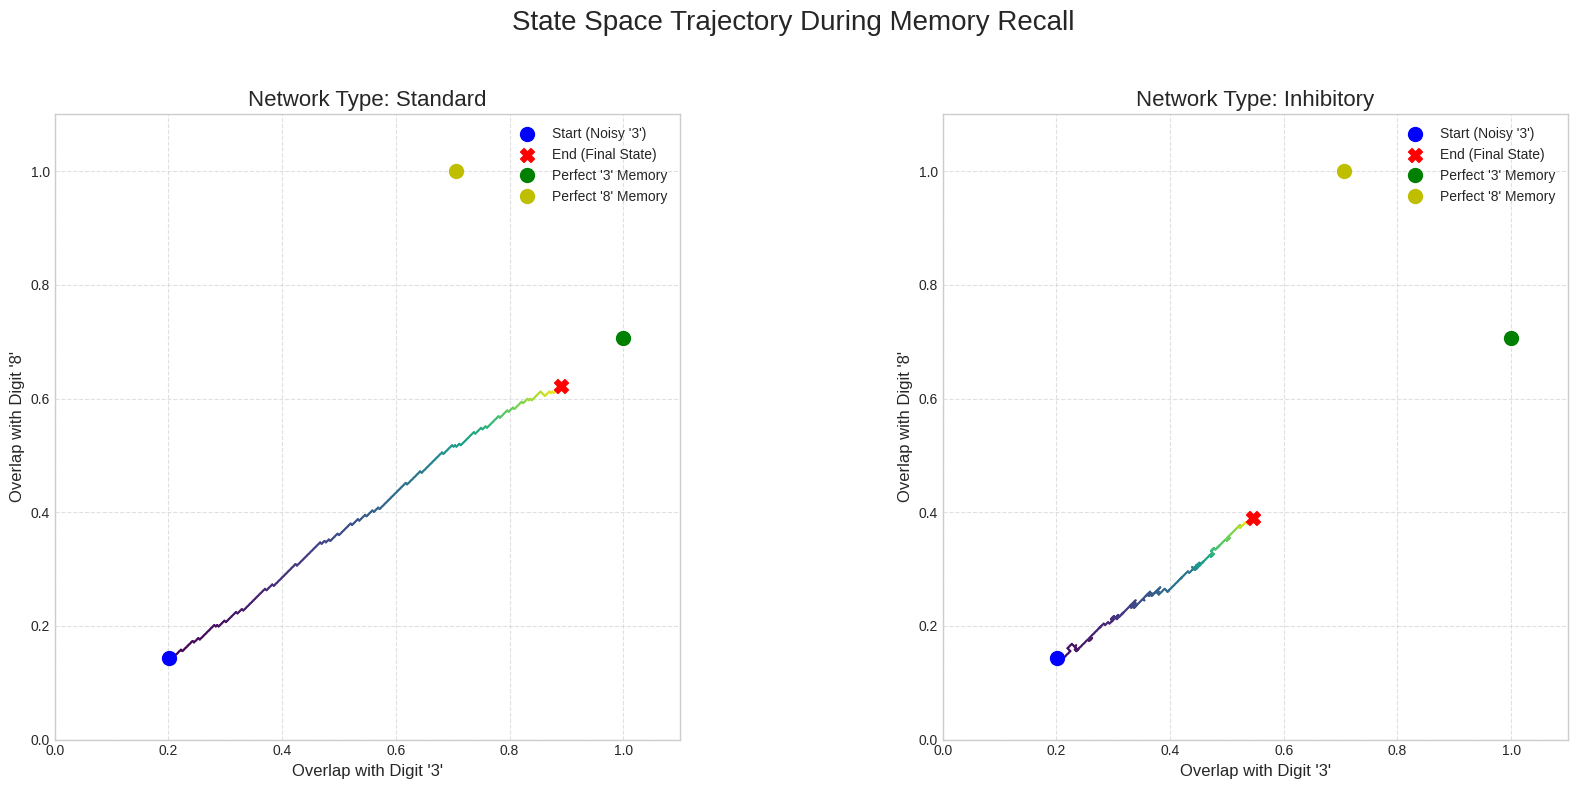

In [9]:
# This cell creates a 2D projection of the energy landscape to visualize the
# recall process. The axes represent the network's similarity (overlap)
# to two distinct, stored memories.

def run_and_plot_trajectory(ax, inhibitory_fraction, patterns_to_use, noise_level=0.4):
    """
    A dedicated function to run a single recall and plot its trajectory in the state space.
    - ax: The matplotlib axis object to plot on.
    - inhibitory_fraction: The fraction of inhibitory neurons for the network.
    - patterns_to_use: A dictionary containing the target patterns.
    - noise_level: The amount of corruption for the initial input.
    """
    # --- 1. Setup the specific experiment ---
    # We will train the network on two visually similar digits, '3' and '8'.
    pattern_A = patterns_to_use[3]
    pattern_B = patterns_to_use[8]

    # Create and train the network
    net = HopfieldNetwork(CONFIG["NUM_NEURONS"], inhibitory_fraction=inhibitory_fraction)
    net.train([pattern_A, pattern_B])

    # Create a noisy version of pattern_A (the digit '3') as our starting point
    initial_state = pattern_A.copy()
    num_to_flip = int(noise_level * CONFIG["NUM_NEURONS"])
    flip_indices = np.random.choice(range(CONFIG["NUM_NEURONS"]), size=num_to_flip, replace=False)
    initial_state[flip_indices] *= -1

    # --- 2. Perform recall and record the state history ---
    state_history = [initial_state.copy()]
    current_state = initial_state.copy()
    for _ in range(CONFIG["MAX_RECALL_STEPS"]):
        neuron_to_update = np.random.randint(CONFIG["NUM_NEURONS"])
        local_field = np.dot(net.weights[neuron_to_update, :], current_state)
        new_state_i = 1 if local_field >= 0 else -1
        current_state[neuron_to_update] = new_state_i
        state_history.append(current_state.copy())

    # --- 3. Calculate overlap trajectory ---
    # For each state in the history, calculate its overlap with our two target memories.
    overlap_A_history = [calculate_overlap(s, pattern_A) for s in state_history]
    overlap_B_history = [calculate_overlap(s, pattern_B) for s in state_history]

    # --- 4. Plot the trajectory ---
    # The x-axis is the overlap with '3', the y-axis is the overlap with '8'.
    num_steps = len(overlap_A_history)
    # Create a color gradient that changes over time (from blue to red)
    colors = plt.cm.viridis(np.linspace(0, 1, num_steps))

    # Plot the path as a series of connected, colored points
    for i in range(num_steps - 1):
        ax.plot(overlap_A_history[i:i+2], overlap_B_history[i:i+2], color=colors[i], lw=1.5)

    # Mark the start and end points
    ax.scatter(overlap_A_history[0], overlap_B_history[0], color='blue', s=100, zorder=10, label='Start (Noisy \'3\')')
    ax.scatter(overlap_A_history[-1], overlap_B_history[-1], color='red', s=100, zorder=10, marker='X', label='End (Final State)')

    # Mark the location of the "perfect" memories in this space
    ax.plot(1, calculate_overlap(pattern_A, pattern_B), 'go', markersize=10, label='Perfect \'3\' Memory')
    ax.plot(calculate_overlap(pattern_B, pattern_A), 1, 'yo', markersize=10, label='Perfect \'8\' Memory')

    ax.set_title(f'Network Type: {"Inhibitory" if inhibitory_fraction > 0 else "Standard"}', fontsize=16)
    ax.set_xlabel("Overlap with Digit '3'", fontsize=12)
    ax.set_ylabel("Overlap with Digit '8'", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_aspect('equal', adjustable='box')


# --- Main execution for this visualization ---
# Create a figure with two subplots side-by-side to compare the two network types.
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('State Space Trajectory During Memory Recall', fontsize=20)

# Run the experiment and plot for the Standard Network
run_and_plot_trajectory(axes[0], inhibitory_fraction=0.0, patterns_to_use=all_patterns)

# Run the experiment and plot for the Inhibitory Network
run_and_plot_trajectory(axes[1], inhibitory_fraction=0.2, patterns_to_use=all_patterns)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

CELL 9: THE ANATOMY OF MEMORY (WEIGHT MATRIX)

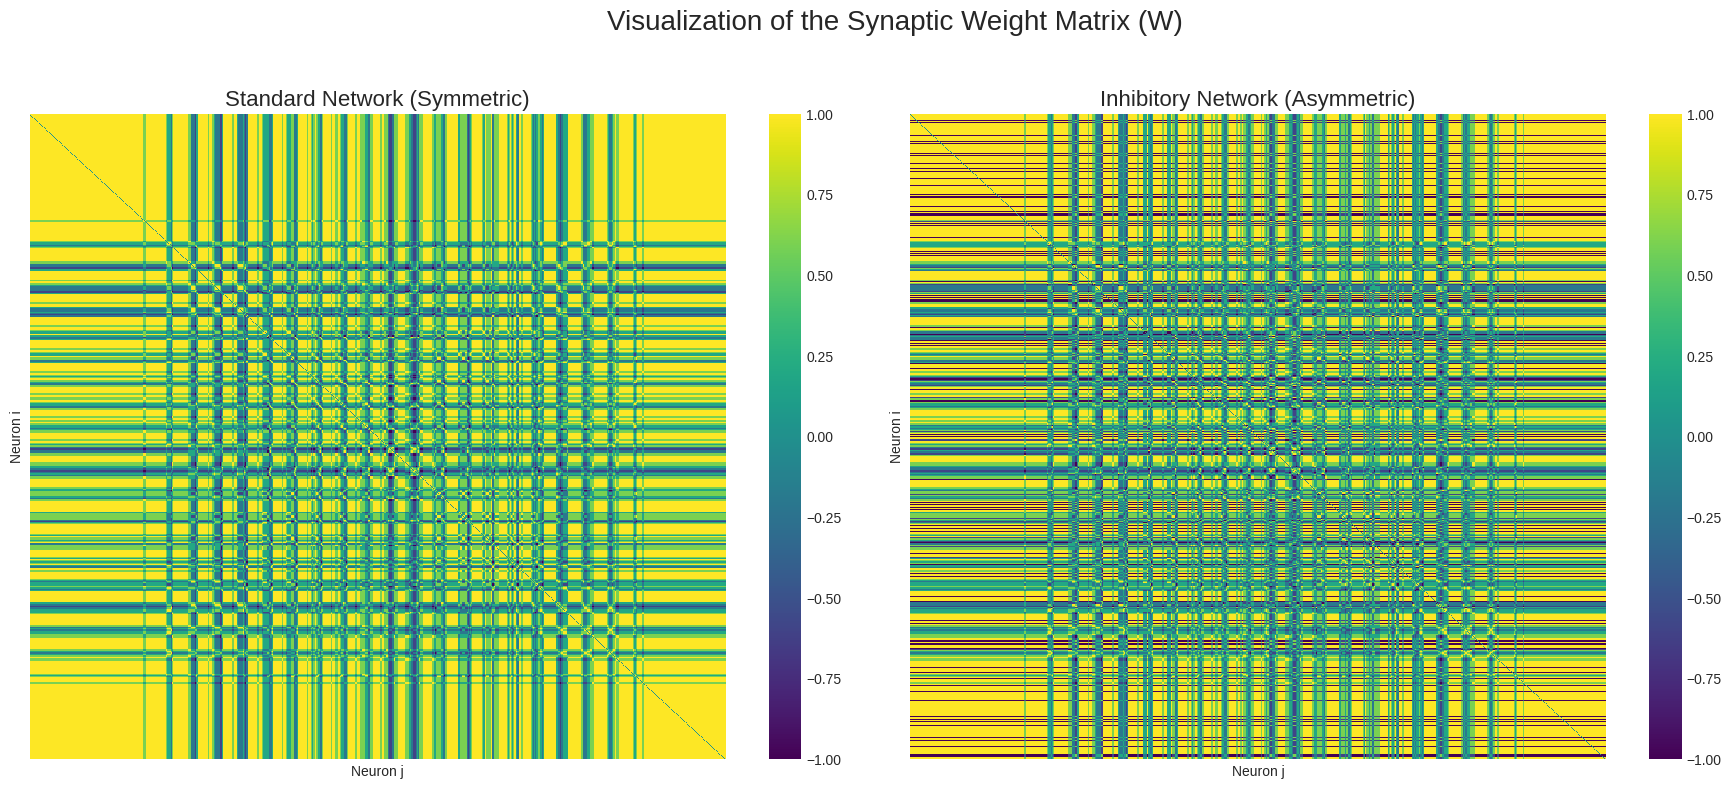

In [10]:
# This cell trains two networks (one standard and one inhibitory) and visualizes
# their synaptic weight matrix (W). This allows us to see the physical
# structure where memories are stored and to observe the structural
# impact of inhibition.

def run_and_plot_weight_matrix(ax, inhibitory_fraction, patterns_to_use, title):
    """
    A dedicated function to train a network and visualize its weight matrix.
    - ax: The matplotlib axis object to plot on.
    - inhibitory_fraction: The fraction of inhibitory neurons for the network.
    - patterns_to_use: A dictionary containing the patterns to be memorized.
    - title: The title for the subplot.
    """
    # --- 1. Setup and Training of the Network ---
    # We use a subset of patterns for training (e.g., the first 5 digits)
    patterns = [patterns_to_use[d] for d in [0, 1, 2, 3, 4]]

    net = HopfieldNetwork(CONFIG["NUM_NEURONS"], inhibitory_fraction=inhibitory_fraction)
    net.train(patterns)

    # --- 2. Visualization of the Weight Matrix ---
    # We use seaborn.heatmap for a clear visualization with a color bar.
    # 'viridis' is a perceptually uniform colormap.
    sns.heatmap(net.weights, ax=ax, cmap='viridis', cbar=True)

    ax.set_title(title, fontsize=16)
    # We remove the axis labels for a cleaner visualization,
    # since 784 ticks would not be readable.
    ax.set_xlabel("Neuron j")
    ax.set_ylabel("Neuron i")
    ax.set_xticks([])
    ax.set_yticks([])


# --- Main Execution for this Cell ---
# We create a figure with two subplots side-by-side to compare the two network types.
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Visualization of the Synaptic Weight Matrix (W)', fontsize=20)

# Run the experiment and plot for the Standard Network
run_and_plot_weight_matrix(axes[0],
                           inhibitory_fraction=0.0,
                           patterns_to_use=all_patterns,
                           title="Standard Network (Symmetric)")

# Run the experiment and plot for the Inhibitory Network
run_and_plot_weight_matrix(axes[1],
                           inhibitory_fraction=0.2,
                           patterns_to_use=all_patterns,
                           title="Inhibitory Network (Asymmetric)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

CELL 10: ANIMATED RECALL

In [20]:
# This cell creates an animation (GIF) of the recall process, showing the
# network state (the digit image) evolving over time. It provides a dynamic
# view of the "error correction" process.

# We need a couple of extra imports for creating and displaying the animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def run_and_generate_animation(inhibitory_fraction, patterns_to_use, digit_to_test=8, noise_level=0.2, animation_steps=800):
    """
    A dedicated function to run a single recall and generate an animation of the process.
    - inhibitory_fraction: The fraction of inhibitory neurons.
    - patterns_to_use: A dictionary of the patterns to be stored.
    - digit_to_test: The digit we will corrupt and try to recall.
    - noise_level: The amount of corruption for the initial input.
    - animation_steps: The number of update steps to record for the animation.
    """
    print(f"\n--- Generating Animation (Network: {'Inhibitory' if inhibitory_fraction > 0 else 'Standard'}) ---")

    # --- 1. Setup the network and initial state ---
    # We store a few patterns for the test.
    patterns = [patterns_to_use[d] for d in [0, 1, 3, 5, 8]]
    net = HopfieldNetwork(CONFIG["NUM_NEURONS"], inhibitory_fraction=inhibitory_fraction)
    net.train(patterns)

    original_pattern = patterns_to_use[digit_to_test]

    # Create a noisy version of the pattern
    noisy_pattern = original_pattern.copy()
    np.random.seed(43) # Use a fixed seed for reproducible noise
    num_to_flip = int(noise_level * CONFIG["NUM_NEURONS"])
    flip_indices = np.random.choice(range(CONFIG["NUM_NEURONS"]), size=num_to_flip, replace=False)
    noisy_pattern[flip_indices] *= -1

    # --- 2. Perform recall and record the state history ---
    # We run a custom loop to store the full state vector at each step.
    state_history = [noisy_pattern.copy()]
    current_state = noisy_pattern.copy()
    for _ in range(animation_steps):
        neuron_to_update = np.random.randint(CONFIG["NUM_NEURONS"])
        local_field = np.dot(net.weights[neuron_to_update, :], current_state)
        new_state_i = 1 if local_field >= 0 else -1
        current_state[neuron_to_update] = new_state_i
        # Store the state every few steps to make the animation smoother and faster to generate
        if _ % 5 == 0:
             state_history.append(current_state.copy())

    # --- 3. Create the animation ---
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.close() # Prevent the static plot from showing up

    # This function will be called for each frame of the animation
    def animate(i):
        ax.clear()
        plot_digit(state_history[i], ax, title=f"Recall Step: {i*5}")

    # Create the animation object.
    # interval=50 means 50 milliseconds between frames.
    anim = FuncAnimation(fig, animate, frames=len(state_history), interval=50, blit=False)

    # To display the animation in Colab, we convert it to an HTML5 video.
    return HTML(anim.to_html5_video())

# --- Main execution for this cell ---
# Generate and display the animation for the standard network.
animation_standard = run_and_generate_animation(0.0, all_patterns)
print("Standard Network Animation Ready.")

# Generate and display the animation for the inhibitory network.
animation_inhibitory = run_and_generate_animation(0.2, all_patterns)
print("Inhibitory Network Animation Ready.")

# Display the animations
print("\n--- Recall Animation for Standard Network ---")
display(animation_standard)

print("\n--- Recall Animation for Inhibitory Network ---")
display(animation_inhibitory)


--- Generating Animation (Network: Standard) ---
Standard Network Animation Ready.

--- Generating Animation (Network: Inhibitory) ---
Inhibitory Network Animation Ready.

--- Recall Animation for Standard Network ---



--- Recall Animation for Inhibitory Network ---


CELL 11: DEMONSTRATION OF THE FULL RECALL PROCESS

Creating full recall visualization for digit '5' with 35% noise.
Final overlap with original pattern: 0.781


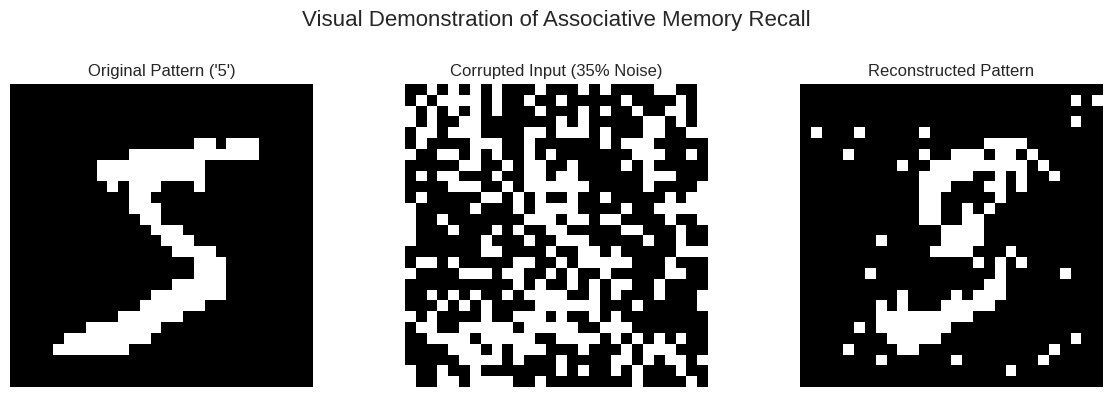

In [12]:
# This cell creates a complete visual narrative: it shows an original memory
# pattern, its corrupted version, and the final pattern reconstructed by the
# Hopfield network.

# --- Parameters for this specific visualization ---
DIGIT_TO_SHOW = 5  # The digit we want to use for the demonstration.
NOISE_LEVEL_DEMO = 0.35  # The fraction of noise to apply (35%).
# We will train on a few digits to make the recall task non-trivial.
PATTERNS_TO_TRAIN_ON = [0, 1, 3, 5, 8]

print(f"Creating full recall visualization for digit '{DIGIT_TO_SHOW}' with {int(NOISE_LEVEL_DEMO*100)}% noise.")

# --- 1. Data and Network Preparation ---
# Retrieve the original pattern from our 'all_patterns' dictionary.
original_pattern_demo = all_patterns[DIGIT_TO_SHOW]

# Create a noisy version of the pattern.
noisy_pattern_demo = original_pattern_demo.copy()
num_to_flip_demo = int(NOISE_LEVEL_DEMO * CONFIG["NUM_NEURONS"])
np.random.seed(101) # Use a fixed seed for reproducible noise.
flip_indices_demo = np.random.choice(range(CONFIG["NUM_NEURONS"]), size=num_to_flip_demo, replace=False)
noisy_pattern_demo[flip_indices_demo] *= -1

# --- 2. Run the Recall Process ---
# Create and train a standard Hopfield network for this demonstration.
patterns_for_training = [all_patterns[d] for d in PATTERNS_TO_TRAIN_ON]
net_demo = HopfieldNetwork(CONFIG["NUM_NEURONS"], inhibitory_fraction=0.0)
net_demo.train(patterns_for_training)

# Run the recall process on the noisy input.
recalled_state_demo, _ = net_demo.recall(noisy_pattern_demo, max_steps=CONFIG["MAX_RECALL_STEPS"], record_energy=False)
final_overlap_demo = calculate_overlap(recalled_state_demo, original_pattern_demo)
print(f"Final overlap with original pattern: {final_overlap_demo:.3f}")


# --- 3. Plot Creation ---
# We create a figure with three subplots to show the full story.
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Visual Demonstration of Associative Memory Recall', fontsize=16)

# Panel 1
plot_digit(original_pattern_demo, axes[0], title=f"Original Pattern ('{DIGIT_TO_SHOW}')")

# Panel 2
plot_digit(noisy_pattern_demo, axes[1], title=f"Corrupted Input ({int(NOISE_LEVEL_DEMO*100)}% Noise)")

# Panel 3
plot_digit(recalled_state_demo, axes[2], title="Reconstructed Pattern")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()